In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

print('Intialized')

Intialized


In [2]:
# place each CSV into it's own data frame since I am trying to predict each body of water flow, volume, and/or hydrometry seperately
Aquifer_Auser = pd.read_csv('Aquifer_Auser.csv')
Aquifer_Doganella = pd.read_csv('Aquifer_Doganella.csv')
Aquifer_Luco = pd.read_csv('Aquifer_Luco.csv')
Aquifer_Petrignano = pd.read_csv('Aquifer_Petrignano.csv')
Lake_Bilancino = pd.read_csv('Lake_Bilancino.csv')
River_Arno = pd.read_csv('River_Arno.csv')
Water_Spring_Amiata = pd.read_csv('Water_Spring_Amiata.csv')
Water_Spring_Lupa = pd.read_csv('Water_Spring_Lupa.csv')
Water_Spring_Madonna_di_Canneto = pd.read_csv('Water_Spring_Madonna_di_Canneto.csv')

# Then print the shape of each DF to look for where I should start analysis (start small work up)
print(f"Water_Spring_Madonna_di_Canneto:{Water_Spring_Madonna_di_Canneto.shape},\nWater_Spring_Lupa:{Water_Spring_Lupa.shape},\nWater_Spring_Amiata:{Water_Spring_Amiata.shape},\nRiver_Arno:{River_Arno.shape},\nLake_Bilancino:{Lake_Bilancino.shape},\nAquifer_Petrignano:{Aquifer_Petrignano.shape},\nAquifer_Luco:{Aquifer_Luco.shape}, \nAquifer_Doganella:{Aquifer_Doganella.shape},\nAquifer_Auser:{Aquifer_Auser.shape}")

Water_Spring_Madonna_di_Canneto:(3113, 4),
Water_Spring_Lupa:(4199, 3),
Water_Spring_Amiata:(7487, 16),
River_Arno:(8217, 17),
Lake_Bilancino:(6603, 9),
Aquifer_Petrignano:(5223, 8),
Aquifer_Luco:(7487, 22), 
Aquifer_Doganella:(6026, 22),
Aquifer_Auser:(8154, 27)


After looking at the shape of each DF I will start with Water_Spring_Lupa as it has the least amount of features to work with. Let's start by looking at the basics of the data looking at descirption, columns, trying to find distributions, etc

In [3]:
Water_Spring_Lupa.columns

Index(['Date', 'Rainfall_Terni', 'Flow_Rate_Lupa'], dtype='object')

In [4]:
Water_Spring_Lupa.describe()

,Rainfall_Terni,Flow_Rate_Lupa
count,4199.000000,3817.000000
mean,2.466355,-97.712916
std,2.041837,15.026314
min,0.000000,-182.310000
25%,1.402000,-105.760000
50%,2.142000,-96.590000
75%,3.165000,-87.220000
max,76.000000,0.000000


In [5]:
Water_Spring_Lupa.dtypes

Date               object
Rainfall_Terni    float64
Flow_Rate_Lupa    float64
dtype: object

In [6]:
print(Water_Spring_Lupa.isnull().sum()/Water_Spring_Lupa.shape[0] * 100)
print()
print(f"Number of missing Flow_Rate_Lupa values: {Water_Spring_Lupa['Flow_Rate_Lupa'].isnull().sum()/Water_Spring_Lupa.shape[0] * Water_Spring_Lupa.shape[0]}")


Date              0.000000
Rainfall_Terni    0.000000
Flow_Rate_Lupa    9.097404
dtype: float64

Number of missing Flow_Rate_Lupa values: 382.0


Less than 10% of the target variable data is missing. However, due to this problem being a time series problem, we do not want to drop the null values Imputing the null values for the target variable can be tricky and cause issues.  My current assumption is that there is seaonalility AND trend present in the data. Let's explore further.

In [7]:
Water_Spring_Lupa['Date']

0       01/01/2009
1       02/01/2009
2       03/01/2009
3       04/01/2009
4       05/01/2009
           ...    
4194    26/06/2020
4195    27/06/2020
4196    28/06/2020
4197    29/06/2020
4198    30/06/2020
Name: Date, Length: 4199, dtype: object

In [8]:
# First we need to convert the date object into a datetime object
Water_Spring_Lupa['Date'] = pd.to_datetime(Water_Spring_Lupa['Date'])
# Then we need to sort the index by date and assign it to the the index
Water_Spring_Lupa = Water_Spring_Lupa.sort_values(by='Date')
Water_Spring_Lupa.set_index('Date', inplace = True)

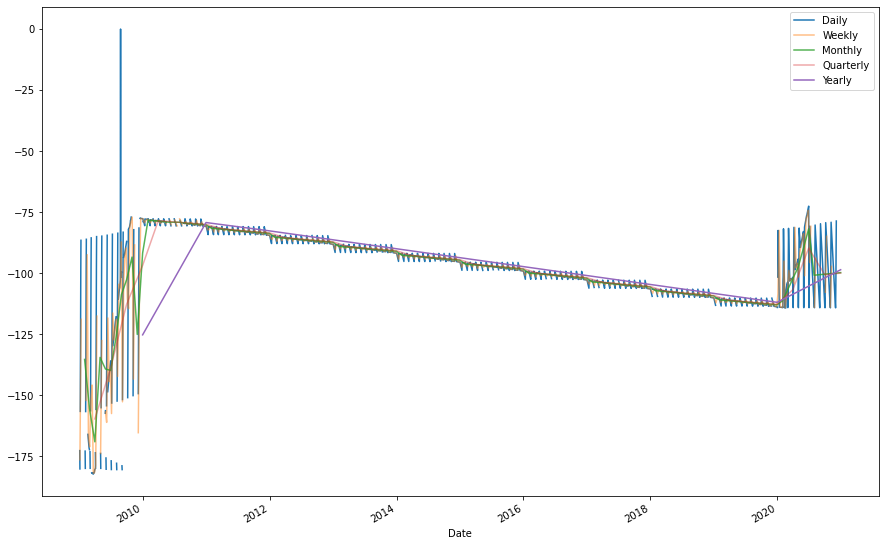

In [9]:
# Finally, let's look at the flow rate(target variable) in at different time intervals. Since we are looking at a usage metric, mean is the best aggreation.
plt.figure(figsize=(15,10))
Water_Spring_Lupa['Flow_Rate_Lupa'].plot(label='Daily')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('W').mean().plot(alpha=.5, label='Weekly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('M').mean().plot(alpha=.8, label='Monthly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('Q').mean().plot(alpha=.4, label='Quarterly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('Y').mean().plot(label='Yearly')
plt.legend()

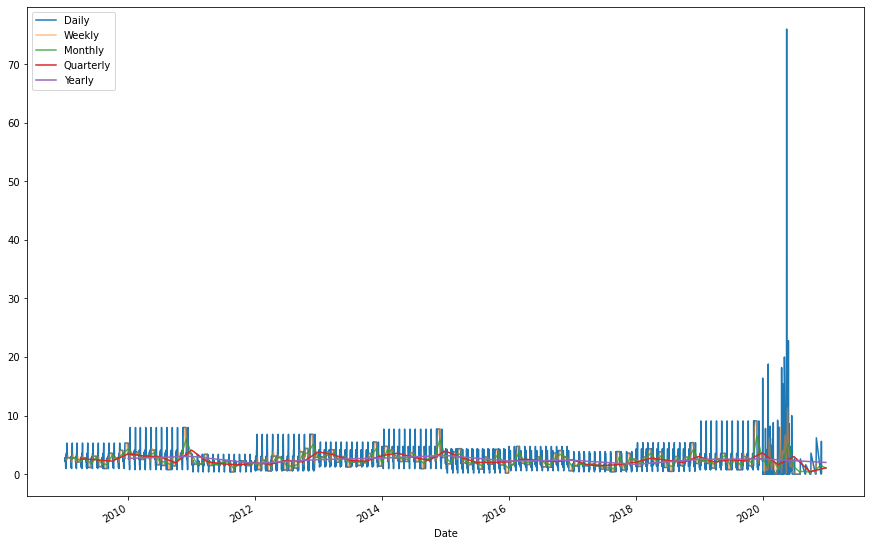

In [10]:
# let's look at the rainfall in different break downs
plt.figure(figsize=(15,10))
Water_Spring_Lupa['Rainfall_Terni'].plot(label='Daily')
Water_Spring_Lupa['Rainfall_Terni'].resample('W').mean().plot(alpha=.5, label='Weekly')
Water_Spring_Lupa['Rainfall_Terni'].resample('M').mean().plot(alpha=.8, label='Monthly')
Water_Spring_Lupa['Rainfall_Terni'].resample('Q').mean().plot(label='Quarterly')
Water_Spring_Lupa['Rainfall_Terni'].resample('Y').mean().plot(label='Yearly')
plt.legend()

Flow data appearsa to be inconsistent prior to 2010 while rainfall data appears to be realatively consistent throughout the whole data set. Since flow is the target variable, it is advised to trim the data to be 2010-2020. Additional triming maybe required due to the outliers that exist in rain data for 2020. 

In [11]:
# Trim the DFto ignore year 2009
Water_Spring_Lupa = Water_Spring_Lupa[Water_Spring_Lupa.index > "2009-12-31"]

# Find instances where the flow rate is null
Water_Spring_Lupa[Water_Spring_Lupa['Flow_Rate_Lupa'].isnull()]

,Rainfall_Terni,Flow_Rate_Lupa
Date,,
2010-01-06,1.597,NaN
2010-01-07,1.477,NaN
2010-01-08,0.758,NaN
2010-02-06,1.597,NaN
2010-02-07,1.477,NaN
...,...,...
2019-08-19,0.733,NaN
2019-09-10,1.436,NaN
2019-10-10,1.436,NaN


In [12]:
# For the time being, I will inpute null values with the monthly mean for each month with null values

# Create a year_month columns
Water_Spring_Lupa['year_month'] = Water_Spring_Lupa.index.strftime('%Y-%m')
# Reset the index in order to keep the date column after merging
Water_Spring_Lupa = Water_Spring_Lupa.reset_index()

# Create an avg_flow DF that groups by the year_month column to get the avg monthly flow rate
avg_flow = Water_Spring_Lupa[['Flow_Rate_Lupa', 'year_month']].groupby('year_month').mean()
avg_flow.columns = ['avg_flow']

# Take the original Water_Spring_Lupa DF and merge it with the avg_flow on the year_month column to pair the avg_flow with each date
Water_Spring_Lupa = Water_Spring_Lupa.merge(avg_flow, how='left', on='year_month')
# Set the index back to date
Water_Spring_Lupa = Water_Spring_Lupa.set_index('Date')
# Use np.where function to replace 
Water_Spring_Lupa['Flow_Rate_Lupa'] = np.where(Water_Spring_Lupa['Flow_Rate_Lupa'].isnull(), 
                                               Water_Spring_Lupa['avg_flow'], Water_Spring_Lupa['Flow_Rate_Lupa'])

#Drop avg_flow column 
Water_Spring_Lupa.drop(columns=['avg_flow'], inplace=True)
Water_Spring_Lupa

,Rainfall_Terni,Flow_Rate_Lupa,year_month
Date,,,
2010-01-01,3.273,-77.69,2010-01
2010-01-02,3.739,-78.00,2010-01
2010-01-03,2.508,-78.28,2010-01
2010-01-04,3.165,-79.11,2010-01
2010-01-05,4.100,-78.89,2010-01
...,...,...,...
2020-12-02,0.200,-114.19,2020-12
2020-12-03,0.000,-103.34,2020-12
2020-12-04,0.000,-98.80,2020-12
